In [1]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
import numpy as np
from scipy.stats import norm
import sys
import os
sys.path.append(os.path.abspath(".."))
from pricing.black_scholes import *

Let's visualize basic behaviors of Delta function

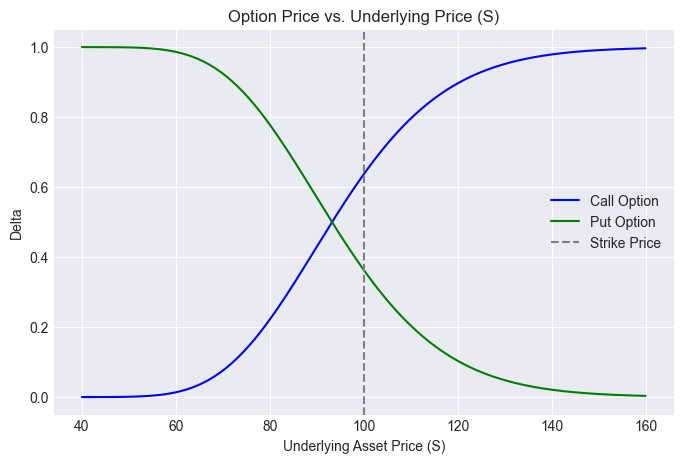

In [2]:
S_vals = np.linspace(40, 160, 200)
K = 100
T = 1
r = 0.05
sigma = 0.2

call_prices = [delta(S, K, T, r, sigma, "call") for S in S_vals]
put_prices = [delta(S, K, T, r, sigma, "put") for S in S_vals]

plt.figure(figsize=(8,5))
plt.plot(S_vals, call_prices, label="Call Option", color="blue")
plt.plot(S_vals, put_prices, label="Put Option", color="green")
plt.axvline(K, linestyle="--", color="gray", label="Strike Price")
plt.title("Option Price vs. Underlying Price (S)")
plt.xlabel("Underlying Asset Price (S)")
plt.ylabel("Delta")
plt.legend()
plt.grid(True)
plt.show()

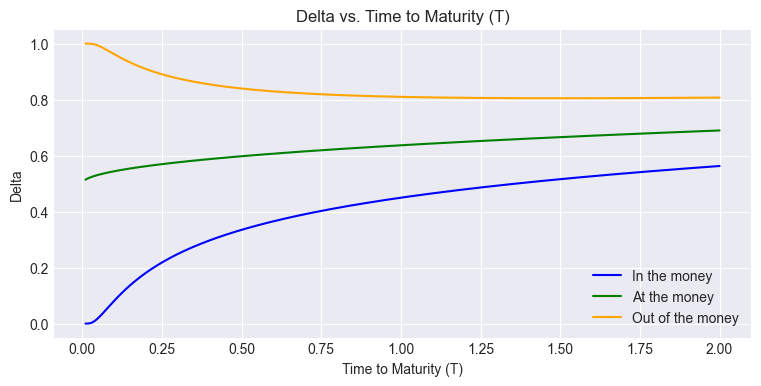

In [68]:
T_vals = np.linspace(0.01, 2, 1000)
S = 100

in_the_money = [delta(S, 110, T, r, sigma, "call") for T in T_vals]
at_the_money = [delta(S, 100, T, r, sigma, "call") for T in T_vals]
out_of_the_money = [delta(S, 90, T, r , sigma, "call") for T in T_vals]

plt.figure(figsize=(9,4))
plt.plot(T_vals, in_the_money, label="In the money", color="blue")
plt.plot(T_vals, at_the_money, label="At the money", color="green")
plt.plot(T_vals, out_of_the_money, label="Out of the money", color="orange")
plt.title("Delta vs. Time to Maturity (T)")
plt.xlabel("Time to Maturity (T)")
plt.ylabel("Delta")
plt.legend()
plt.grid(True)
plt.show() 

Simulate the Brownian procces:

In [102]:
M = 10_000 # Number of paths
T = 1 # Years
N = T * 252
dt = T/N 
mu = 0.15 # Expected return per annum: 15%
sigma = 0.2
S0 = 100

# Initialize matrix: M paths, N+1 dots (including S0)
S_paths = np.zeros((M, N + 1))
S_paths[:, 0] = S0

# Generate random values for all steps in one go
Z = np.random.normal(0, 1, size=(M, N)) 

# Now we apply those random values to our GBM solution
increments = np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

for t in range(1, N + 1):
    S_paths[:, t] = S_paths[:, t - 1] * increments[:, t - 1] # Note that S_paths[:, -1] is all zeros at firt so S0 remains the same

Let's plot the simulated paths and the last price distribution after one year:

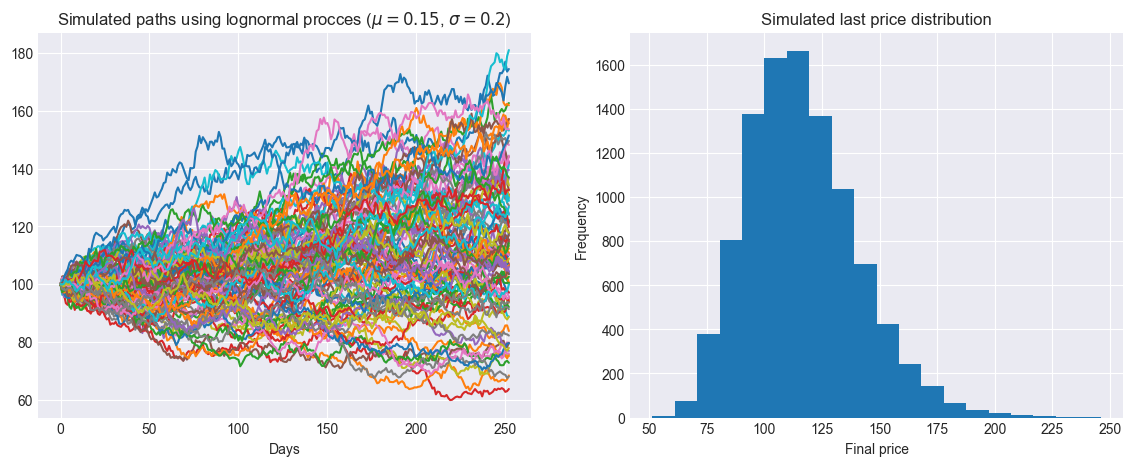

In [103]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 5))
#ax1.figure(figsize = (8,5))
for i in range(100):
    ax1.plot(S_paths[i])

ax2.hist(S_paths[:, -1], bins = 20)

ax1.set_title(r"Simulated paths using lognormal procces ($\mu = 0.15$, $\sigma = 0.2$)")
ax2.set_title("Simulated last price distribution")
ax1.set_xlabel("Days")
ax2.set_ylabel("Price")
ax2.set_xlabel("Final price")
ax2.set_ylabel("Frequency")

plt.grid(True)
plt.show() 

In [104]:
K = 100
r = 0

# Compute delta values
delta_values = np.zeros((M, N + 1))
for idx_step in range(M):
    delta_values[idx_step, :] = delta(S_paths[idx_step, :], K, T , r, sigma) 

option_prices = np.array([black_scholes_price(S_paths[:, 0], K, T, r, sigma)])
cash = option_prices.copy()

# Hedging strategy
cash -= delta_values[:, 0] * S_paths[:, 0] # Buy delta shares to remain delta neutral
hedgingPnL = np.zeros((M, N + 1))
hedgingPnL[:, 0] = cash + delta_values[:, 0]*S_paths[:, 0]

for t in range(1, N+1):
    delta_diff = delta_values[:, t] - delta_values[:, t - 1]
    cash -= delta_diff * S_paths[:, t]
    # No interest gained because r = 0

    hedgingPnL[:, t] = cash + delta_values[:, t] * S_paths[:, t]

# Payoff at maturity
payoff = np.maximum(S_paths[:, -1] - K, 0)

hedging_error = hedgingPnL[:, -1] - payoff

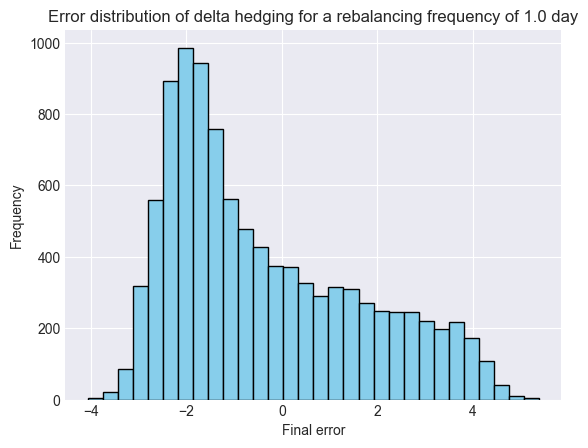

In [111]:
plt.hist(hedging_error, bins=30, color="skyblue", edgecolor = "black")
plt.title(f"Error distribution of delta hedging for a rebalancing frequency of {N/252} day")
plt.xlabel("Final error")
plt.ylabel("Frequency")
plt.grid(True)